In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec

pathstem='/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT1_dens/prod1_corr_ampl/'

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


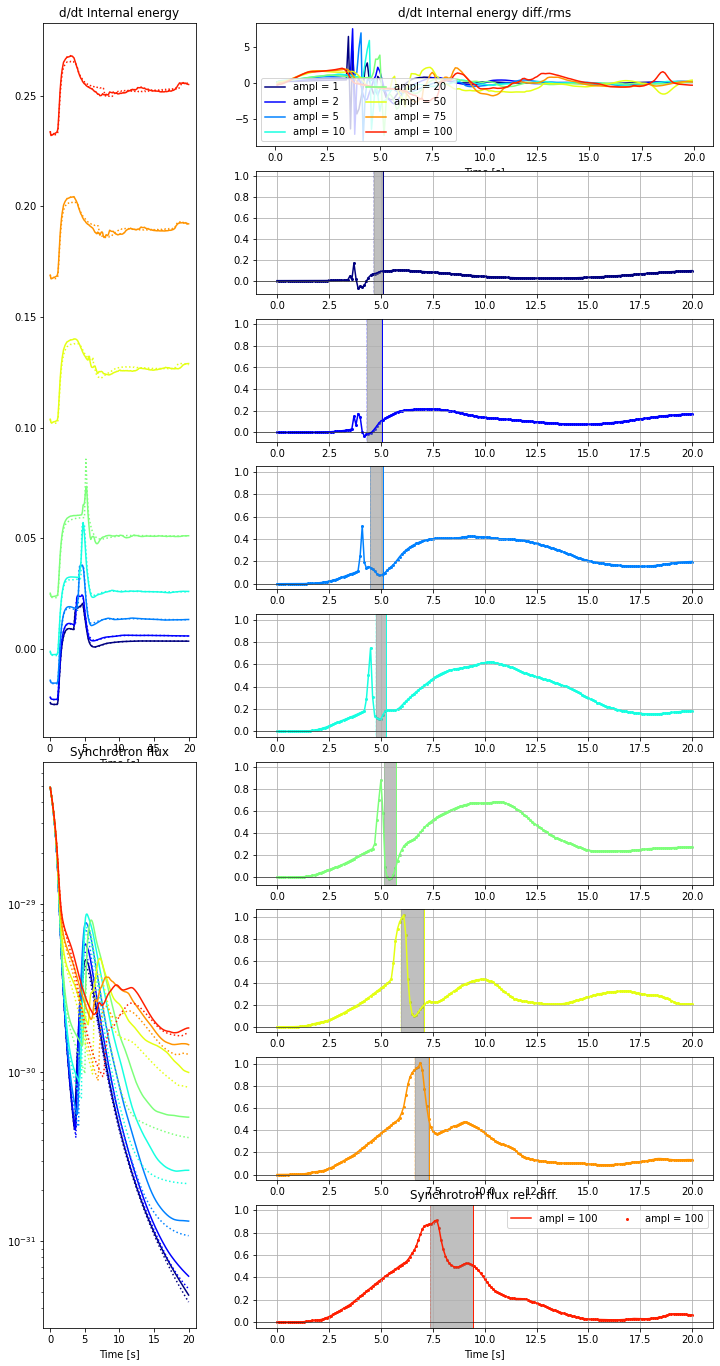

In [5]:
amplitudes = [1,2,5,10,20,50,75,100]
n_ampl = len(amplitudes)

colors = {amplitudes[i]:mplcm.jet(1.0*i/n_ampl) for i in range(n_ampl)}
linestyles = {0:':', 1:'-'}

fig = plt.figure(figsize=(12,24))
gs = gridspec.GridSpec(9,2, width_ratios=[1,3])

# d/dt Internal energy ---------------------------------------
plt.subplot(gs[0:5,0])
for ampl in amplitudes:
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
        
        if corr == 0:
            plt.plot(data['times'][:-1], data['ddt_internal_energy'][:-1], color=colors[ampl], ls=linestyles[corr])
        else:
            plt.plot(data['times'][:-1], data['ddt_internal_energy'][:-1], color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
        
        del data
#plt.legend(ncol=2)
plt.xlabel('Time [s]')
plt.title('d/dt Internal energy')

# d/dt Internal energy difference -----------------------------
plt.subplot(gs[0,1])
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
        
    difference = data[1]['ddt_internal_energy'][:-1] - data[0]['ddt_internal_energy'][:-1]
    #average = 0.5 * (data[1]['ddt_internal_energy'][:-1] + data[0]['ddt_internal_energy'][:-1])
    rms = np.sqrt(np.nanmean(difference**2))
    plt.plot(data[0]['times'][:-1], difference/rms, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
        
    del data

plt.legend(ncol=2)
plt.xlabel('Time [s]')
plt.title('d/dt Internal energy diff./rms')

# Synchrotron flux ------------------------------------------
plt.subplot(gs[5:,0])
for ampl in amplitudes:
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
        
        if corr == 0:
            plt.plot(data['times'], data['flux_density'], color=colors[ampl], ls=linestyles[corr])
        else:
            plt.plot(data['times'], data['flux_density'], color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
        
        del data
plt.gca().set_yscale('log')
#plt.legend(ncol=1)
plt.xlabel('Time [s]')
plt.title('Synchrotron flux')

# Synchrotron flux difference --------------------------------
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
        
    difference = data[1]['flux_density'] - data[0]['flux_density']
    average = 0.5 * (data[1]['flux_density'] + data[0]['flux_density'])
    
    plt.subplot(gs[1+amplitudes.index(ampl),1])
    plt.plot(data[0]['times'], difference/average, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
    plt.scatter(data[0]['times'], difference/average, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl), s=4)
        
    del data

plt.legend(ncol=2)
plt.xlabel('Time [s]')
plt.title('Synchrotron flux rel. diff.')

# Times of collision start and peak emission --------------------------------
for ampl in amplitudes:
    time_start = []
    time_peak = []
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
            
        df = data['flux_density'][1:] - data['flux_density'][:-1]
        dt = data['times'][1:] - data['times'][:-1]
        tavg = 0.5*(data['times'][1:] + data['times'][:-1])

        dfdt = df/dt
        idx_start = np.argmax(dfdt)
        time_start.append(data['times'][idx_start])

        d_dfdt = dfdt[(idx_start+1):] * dfdt[idx_start:-1]
        idx_peak = idx_start + np.where(d_dfdt < 0)[0][0]
        time_peak.append(0.5 * (tavg[idx_peak] + tavg[idx_peak+1]))
        
        del data, df, dt, dfdt, d_dfdt
    
    if False:
        for j in range(2):
            for i in range(2):
                if j*i == 1: continue
                plt.subplot(gs[j,i])
                #plt.fill_between(tavg, -1., 1., where=((tavg > time_start[0]) & (tavg < time_start[1])), transform=plt.gca().get_xaxis_transform())
                plt.axvline(np.mean(time_start), color=colors[ampl], linewidth=0.5, linestyle=":")
                plt.axvline(np.mean(time_peak),  color=colors[ampl], linewidth=1.0, linestyle="-")
            
    plt.subplot(gs[1+amplitudes.index(ampl),1])
    plt.fill_between(tavg, 0,1, where=((tavg >= np.mean(time_start)) & (tavg <= np.mean(time_peak))), transform=plt.gca().get_xaxis_transform(), color='grey', alpha=0.5)
    plt.axvline(np.mean(time_start), color=colors[ampl], linewidth=0.5, linestyle=":")
    plt.axvline(np.mean(time_peak),  color=colors[ampl], linewidth=1.0, linestyle="-")
    
    #plt.ylim(-0.09,0.2)
    plt.axhline(0., color='k', linewidth=0.5)
    plt.grid(True)

if False:
    plt.savefig('pencil_amplitude.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

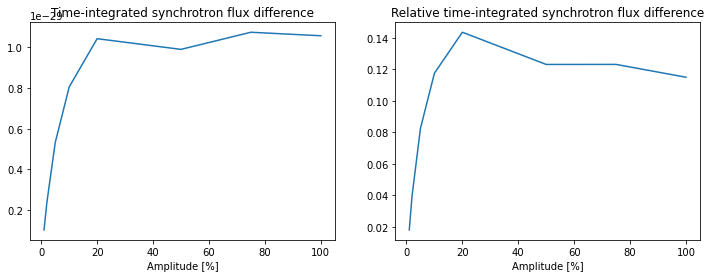

In [3]:
# Integrated net Synchrotron flux difference --------------------------------
synchro_diff_tot = {}
synchro_mean_tot = {}
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
            
    total_emission = 0.5 * (data[1]['flux_density'] + data[0]['flux_density'])
    total_emission = 0.5 * (total_emission[1:] + total_emission[:-1])
        
    difference = data[1]['flux_density'] - data[0]['flux_density']
    difference = 0.5 * (difference[1:] + difference[:-1])
    
    dt = data[0]['times'][1:] - data[0]['times'][:-1]
    
    synchro_diff_tot[ampl] = np.sum(difference*dt)
    synchro_mean_tot[ampl] = np.sum(total_emission*dt)
    
    del data
    
# plot

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(synchro_diff_tot.keys(), synchro_diff_tot.values())
plt.xlabel('Amplitude [%]')
plt.title('Time-integrated synchrotron flux difference')
    
plt.subplot(122)
plt.plot(synchro_diff_tot.keys(), np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())))
plt.xlabel('Amplitude [%]')
plt.title('Relative time-integrated synchrotron flux difference')

plt.show()
plt.close()

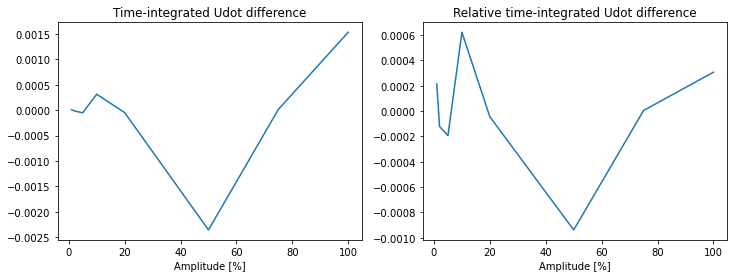

In [4]:
# Integrated net Internal energy time derivative difference --------------------------------
Udot_diff_tot = {}
Udot_mean_tot = {}
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
            
    total_Udot = 0.5 * (data[1]['ddt_internal_energy'][1:-1] + data[0]['ddt_internal_energy'][1:-1])
    total_Udot = 0.5 * (total_Udot[1:] + total_Udot[:-1])
        
    difference = data[1]['ddt_internal_energy'][1:-1] - data[0]['ddt_internal_energy'][1:-1]
    difference = 0.5 * (difference[1:] + difference[:-1])
    
    dt = data[0]['times'][3:] - data[0]['times'][2:-1]
    
    Udot_diff_tot[ampl] = np.sum(difference*dt)
    Udot_mean_tot[ampl] = np.sum(total_Udot*dt)
    
    del data
    
# plot

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(Udot_diff_tot.keys(), Udot_diff_tot.values())
plt.xlabel('Amplitude [%]')
plt.title('Time-integrated Udot difference')
    
plt.subplot(122)
plt.plot(Udot_diff_tot.keys(), np.array(list(Udot_diff_tot.values())) / np.array(list(Udot_mean_tot.values())))
plt.xlabel('Amplitude [%]')
plt.title('Relative time-integrated Udot difference')

plt.show()
plt.close()

------------------------
**Plots for Paper 1**

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 6})

paper1_savepath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/Paper1/plots/'

In [6]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

#constants
e = e.cgs.value
c = c.cgs.value
m_e = m_e.cgs.value
#units
cm = 1.0
gram = 1.0
sec = 1.0
Hz = 1.0
kpc = (1.*u.kpc).cgs.value
Msun = (1.*u.Msun).cgs.value
erg = (1.*u.erg).cgs.value
def get_cgs (x): return x
def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(2.*simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(8.*np.pi*simu_press) # sqrt( erg / cm^3 )

In [7]:
sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [8]:
amplitudes = [1,2,5,10,20]#,50,75,100]
n_ampl = len(amplitudes)

colors = {amplitudes[i]:mplcm.jet(1.0*i/n_ampl) for i in range(n_ampl)}
linestyles = {0:':', 1:'-'}

fig = plt.figure(figsize=(7,8.5))
gs = gridspec.GridSpec(7,2, height_ratios=[1,0.15,1,1,1,1,1], width_ratios=[1,3])

# d/dt Internal energy ---------------------------------------
plt.subplot(gs[0:4,0])
for ampl in amplitudes:
    for corr in [1,]:# [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
        
        if corr == 0:
            plt.plot(
                data['times'][:-1] * sim2phys['Time'],
                data['ddt_internal_energy'][:-1] * sim2phys['ddt_internal_energy'] * 1.0e-4,
                color=colors[ampl],
                ls=linestyles[corr]
            )
        else:
            plt.plot(
                data['times'][:-1] * sim2phys['Time'],
                data['ddt_internal_energy'][:-1] * sim2phys['ddt_internal_energy'] * 1.0e-4,
                color=colors[ampl],
                ls=linestyles[corr],
                label=('ampl = %i' % ampl)
            )
        
        del data
#plt.legend(ncol=2)
#plt.xlabel('Time [s]')
plt.ylabel('d/dt( Internal energy ) [$10^4$erg $/$ (cm$^3$ s)]')
plt.gca().axes.xaxis.set_ticklabels([])
plt.text(0.8,0.94, '(a)', transform=plt.gca().transAxes)

# d/dt Internal energy difference -----------------------------
plt.subplot(gs[0,1])
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
        
    difference = data[1]['ddt_internal_energy'][:-1] - data[0]['ddt_internal_energy'][:-1]
    #average = 0.5 * (data[1]['ddt_internal_energy'][:-1] + data[0]['ddt_internal_energy'][:-1])
    rms = np.sqrt(np.nanmean(difference**2))
    plt.plot(data[0]['times'][:-1], difference/rms, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
        
    del data

plt.legend(ncol=2)
#plt.gca().axes.xaxis.set_ticklabels([])
plt.xlabel('Time [s]')
plt.title('d/dt( Internal energy difference ) / rms')
plt.text(0.05,0.8, '(c)', transform=plt.gca().transAxes)

# Synchrotron flux ------------------------------------------
plt.subplot(gs[4:,0])
for ampl in amplitudes:
    for corr in [1,]:# [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
        
        if corr == 0:
            plt.plot(
                data['times'] * sim2phys['Time'],
                data['flux_density'] * sim2phys['flux_density'],
                color=colors[ampl],
                ls=linestyles[corr]
            )
        else:
            plt.plot(
                data['times'] * sim2phys['Time'],
                data['flux_density'] * sim2phys['flux_density'],
                color=colors[ampl],
                ls=linestyles[corr],
                label=('ampl = %i' % ampl)
            )
        
        del data
plt.gca().set_yscale('log')
#plt.legend(ncol=1)
plt.xlabel('Time [s]')
plt.ylabel('d/dS( Synchrotron flux ) [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')
plt.text(0.8,0.94, '(b)', transform=plt.gca().transAxes)

# Synchrotron flux difference --------------------------------
for ampl in amplitudes:
    data = {}
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data[corr] = pkl.load(f)
        
    difference = data[1]['flux_density'] - data[0]['flux_density']
    average = 0.5 * (data[1]['flux_density'] + data[0]['flux_density'])
    
    plt.subplot(gs[2+amplitudes.index(ampl),1])
    plt.plot(data[0]['times'], difference/average, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl))
    plt.scatter(data[0]['times'], difference/average, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl), s=4)
    
    if ampl != amplitudes[-1]:
        plt.gca().axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('Time [s]')
        
    del data
    
    plt.text(0.07,0.72, '(d%i)' % (amplitudes.index(ampl)+1,), transform=plt.gca().transAxes)
    
plt.subplot(gs[2,1])
plt.title('d/dS( Synchrotron flux ), relative difference')

# Times of collision start and peak emission --------------------------------
for ampl in amplitudes:
    time_start = []
    time_peak = []
    for corr in [0,1]:
        with open(pathstem+'history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
            data = pkl.load(f)
            
        df = data['flux_density'][1:] - data['flux_density'][:-1]
        dt = data['times'][1:] - data['times'][:-1]
        tavg = 0.5*(data['times'][1:] + data['times'][:-1])

        dfdt = df/dt
        idx_start = np.argmax(dfdt)
        time_start.append(data['times'][idx_start])

        d_dfdt = dfdt[(idx_start+1):] * dfdt[idx_start:-1]
        idx_peak = idx_start + np.where(d_dfdt < 0)[0][0]
        time_peak.append(0.5 * (tavg[idx_peak] + tavg[idx_peak+1]))
        
        del data, df, dt, dfdt, d_dfdt
            
    plt.subplot(gs[2+amplitudes.index(ampl),1])
    plt.fill_between(tavg, 0,1, where=((tavg >= np.mean(time_start)) & (tavg <= np.mean(time_peak))), transform=plt.gca().get_xaxis_transform(), color='grey', alpha=0.5)
    #plt.axvline(np.mean(time_start), color=colors[ampl], linewidth=0.5, linestyle=":")
    #plt.axvline(np.mean(time_peak),  color=colors[ampl], linewidth=1.0, linestyle="-")
    
    plt.ylim(-0.09,0.2)
    plt.axhline(0., color='k', linewidth=0.5)
    plt.grid(True)

if True:
    plt.subplots_adjust(left=0.07, bottom=0.04, right=0.95, top=0.97)
    plt.savefig(paper1_savepath + 'pencil_amplitude.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
